<a href="https://colab.research.google.com/github/D-2000-99/Acoustic_Woods/blob/main/Advanced%20House%20Price/Advanced_regression_house.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports and loading data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
data = pd.read_csv('train.csv')

In [4]:
df = data.copy()

In [5]:
print(data.shape)

(1460, 81)


- We notice that the Dataframe consists of 1460 rows and 81 columns, let's look at the first 10 rows to get a better sense of the data.

In [6]:
df.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,...,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,...,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,...,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,...,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,

We drop the Id column as it is irrelevant

In [7]:
df = df.drop('Id',1)

#Data Preprocessing

##Taking care of null values

In [8]:
s = df.isnull().sum()
s.where(s>0).dropna() #remove irrelevant columns from null-value list. 

LotFrontage      259.0
Alley           1369.0
MasVnrType         8.0
MasVnrArea         8.0
BsmtQual          37.0
BsmtCond          37.0
BsmtExposure      38.0
BsmtFinType1      37.0
BsmtFinType2      38.0
Electrical         1.0
FireplaceQu      690.0
GarageType        81.0
GarageYrBlt       81.0
GarageFinish      81.0
GarageQual        81.0
GarageCond        81.0
PoolQC          1453.0
Fence           1179.0
MiscFeature     1406.0
dtype: float64

- Dropping columns where more than 80% of the data is NaN

In [9]:
df_red = df.dropna(thresh=df.shape[0]*0.8,axis=1) #df.shape[0] --> 1460 rows
s = df_red.isnull().sum()
s.where(s>0).dropna()

LotFrontage     259.0
MasVnrType        8.0
MasVnrArea        8.0
BsmtQual         37.0
BsmtCond         37.0
BsmtExposure     38.0
BsmtFinType1     37.0
BsmtFinType2     38.0
Electrical        1.0
GarageType       81.0
GarageYrBlt      81.0
GarageFinish     81.0
GarageQual       81.0
GarageCond       81.0
dtype: float64

- We get all the null columns into a list called null_cols

In [10]:
null_cols = s.where(s>0).dropna().keys()
null_cols = null_cols[0:len(null_cols)]

- Next, we'll check which ones we can impute numerically
Here we can see that LotFrontage, MasVnrArea, GarageYrBlt is numeric and we can use SimpleImputer to fill in the null values

In [11]:
for i in null_cols: 
  if (df_red[f'{i}'].dtype == 'object'):
    print(i,'is categorical')
  else:
    print(i, 'is numeric <---')

LotFrontage is numeric <---
MasVnrType is categorical
MasVnrArea is numeric <---
BsmtQual is categorical
BsmtCond is categorical
BsmtExposure is categorical
BsmtFinType1 is categorical
BsmtFinType2 is categorical
Electrical is categorical
GarageType is categorical
GarageYrBlt is numeric <---
GarageFinish is categorical
GarageQual is categorical
GarageCond is categorical


- Next we will use the SimpleImputer to fill in the null values with the mean of the column

In [12]:
from sklearn.impute import SimpleImputer
for i in null_cols: 
  if df_red[f'{i}'].dtype != 'object':
    imp_mean = SimpleImputer(strategy='mean')
    imp_mean.fit(df_red[[f'{i}']])
    df_red[f'{i}']=imp_mean.fit_transform(df_red[[f'{i}']]).ravel()
    print("Imputing values for:",i)

Imputing values for: LotFrontage
Imputing values for: MasVnrArea
Imputing values for: GarageYrBlt


- Dropping empty rows from categorical columns since null value count is insignificant 

In [13]:
df_red.dropna(inplace=True,subset=null_cols)

- Checking final size of reduced dataset we have 1338 rows and 75 columns

In [14]:
print("Original dataset:", data.shape)
print("Reduced dataset:", df_red.shape)

Original dataset: (1460, 81)
Reduced dataset: (1338, 75)


- After imputing the said values have no more null values, we have no more null values 

In [15]:
s = df_red.isnull().sum()
s.where(s>0).dropna()

Series([], dtype: float64)

##Feature Engineering

- Finding number of years between year built and year sold and adding it as a feature as just the years do not provide enough context.

In [16]:
df_red['Num_years_built_sold'] = df_red['YrSold']-df_red['YearBuilt'] 
df_red['Num_years_built_sold'] #Contains number of years between year Built and Sold

0        5
1       31
2        7
3       91
4        8
        ..
1455     8
1456    32
1457    69
1458    60
1459    43
Name: Num_years_built_sold, Length: 1338, dtype: int64

- Similarly, finding number of years between year remodelled and year sold.

In [17]:
df_red['Num_years_remod_sold'] = df_red['YrSold']-df_red['YearRemodAdd']
df_red['Num_years_remod_sold'] 

0        5
1       31
2        6
3       36
4        8
        ..
1455     7
1456    22
1457     4
1458    14
1459    43
Name: Num_years_remod_sold, Length: 1338, dtype: int64

- Dropping Year Values since it is not relevant to the algorithm.

In [18]:
df_red = df_red.drop(['YrSold','YearBuilt'], 1)

- Dropping highly correlated variables to avoid multicollinearity

In [19]:
df_red = df_red.drop(["TotalBsmtSF","TotRmsAbvGrd"],1)

###We split the entire data into the independent variables(X) and dependent variable(y)

In [20]:
X = df_red.iloc[:,:np.shape(df_red)[1]-3]
y = df_red.iloc[:,np.shape(df_red)[1]-3]

In [21]:
X = pd.concat([X,df_red.iloc[:,np.shape(df_red)[1]-2:]],1)

In [22]:
print('X data')
display(X)
print('y data')
display(pd.DataFrame(y))

X data


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SaleType,SaleCondition,Num_years_built_sold,Num_years_remod_sold
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,WD,Normal,5,5
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,WD,Normal,31,31
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,WD,Normal,7,6
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,WD,Abnorml,91,36
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,WD,Normal,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,Typ,1,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,0,8,WD,Normal,8,7
1456,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,Min1,2,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,0,2,WD,Normal,32,22
1457,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,Typ,2,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,2500,5,WD,Normal,69,4
1458,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,Typ,0,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,0,4,WD,Normal,60,14


y data


,SalePrice
0,208500
1,181500
2,223500
3,140000
4,250000
...,...
1455,175000
1456,210000
1457,266500
1458,142125


- We will now separate the categorical and numeric variables

In [23]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

In [24]:
numeric_col = [i for i in X.columns if is_numeric_dtype(X[i])]
cat_col = [i for i in X.columns if is_numeric_dtype(X[i])==False]

In [25]:
X_numeric = X[numeric_col]
X_cat = X[cat_col]

- There are 34 numeric columns.

In [26]:
print("NUMERIC COLUMN:\n",X_numeric.shape)
X_numeric

NUMERIC COLUMN:
 (1338, 34)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,Num_years_built_sold,Num_years_remod_sold
0,60,65.0,8450,7,5,2003,196.0,706,0,150,856,854,0,1710,1,0,2,1,3,1,0,2003.0,2,548,0,61,0,0,0,0,0,2,5,5
1,20,80.0,9600,6,8,1976,0.0,978,0,284,1262,0,0,1262,0,1,2,0,3,1,1,1976.0,2,460,298,0,0,0,0,0,0,5,31,31
2,60,68.0,11250,7,5,2002,162.0,486,0,434,920,866,0,1786,1,0,2,1,3,1,1,2001.0,2,608,0,42,0,0,0,0,0,9,7,6
3,70,60.0,9550,7,5,1970,0.0,216,0,540,961,756,0,1717,1,0,1,0,3,1,1,1998.0,3,642,0,35,272,0,0,0,0,2,91,36
4,60,84.0,14260,8,5,2000,350.0,655,0,490,1145,1053,0,2198,1,0,2,1,4,1,1,2000.0,3,836,192,84,0,0,0,0,0,12,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,2000,0.0,0,0,953,953,694,0,1647,0,0,2,1,3,1,1,1999.0,2,460,0,40,0,0,0,0,0,8,8,7
1456,20,85.0,13175,6,6,1988,119.0,790,163,589,2073,0,0,2073,1,0,2,0,3,1,2,1978.0,2,500,349,0,0,0,0,0,0,2,32,22
1457,70,66.0,9042,7,9,2006,0.0,275,0,877,1188,1152,0,2340,0,0,2,0,4,1,2,1941.0,1,252,0,60,0,0,0,0,2500,5,69,4
1458,20,68.0,9717,5,6,1996,0.0,49,1029,0,1078,0,0,1078,1,0,1,0,2,1,0,1950.0,1,240,366,0,112,0,0,0,0,4,60,14


- There are 38 categorical columns.

In [27]:
print("CATEGORICAL COLUMN:\n",X_cat.shape)
X_cat

CATEGORICAL COLUMN:
 (1338, 38)


,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,Plywood,Plywood,Stone,TA,TA,CBlock,Gd,TA,No,ALQ,Rec,GasA,TA,Y,SBrkr,TA,Min1,Attchd,Unf,TA,TA,Y,WD,Normal
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,CemntBd,CmentBd,None,Ex,Gd,Stone,TA,Gd,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1458,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,TA,TA,Mn,GLQ,Rec,GasA,Gd,Y,FuseA,Gd,Typ,Attchd,Unf,TA,TA,Y,WD,Normal


#EDA

In [28]:
df_red.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice,Num_years_built_sold,Num_years_remod_sold
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.00000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.00000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,56.136024,70.630187,10706.294469,6.219731,5.596413,1985.668909,110.360239,464.234679,49.218236,582.494768,1176.221973,357.141256,4.221973,1537.585202,0.438714,0.060538,1.575486,0.402840,2.864723,1.029895,0.648729,1978.596413,1.87145,501.449925,99.384903,47.782511,21.263827,3.585949,16.43423,3.010463,42.932735,6.331839,186761.782511,34.776532,22.136771
std,41.252576,22.161578,10336.621126,1.324472,1.078124,20.296463,185.604816,458.792420,166.196584,439.950528,386.644986,440.324982,40.712916,520.579960,0.515630,0.241685,0.547570,0.504185,0.776677,0.174697,0.645393,24.773741,0.63428,186.761863,127.537065,65.362562,60.843964,30.224622,58.05159,41.961337,508.056255,2.699437,78913.847668,29.603970,20.294171
min,20.000000,21.000000,1300.000000,2.000000,2.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,438.000000,0.000000,0.000000,438.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1900.000000,1.00000,160.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,35311.000000,0.000000,-1.000000
25%,20.000000,60.000000,7744.000000,5.000000,5.000000,1968.000000,0.000000,0.000000,0.000000,248.000000,894.000000,0.000000,0.000000,1160.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,0.000000,1962.000000,1.00000,377.500000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,5.000000,135000.000000,7.000000,4.000000
50%,50.000000,70.049958,9600.000000,6.000000,5.000000,1994.500000,0.000000,413.000000,0.000000,489.000000,1098.000000,0.000000,0.000000,1480.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,1.000000,1980.000000,2.00000,484.000000,6.000000,28.000000,0.000000,0.000000,0.00000,0.000000,0.000000,6.000000,168500.000000,33.000000,14.000000
75%,70.000000,80.000000,11760.750000,7.000000,6.000000,2004.000000,174.000000,733.000000,0.000000,815.750000,1414.000000,740.500000,0.000000,1791.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2002.000000,2.00000,583.000000,174.500000,70.000000,0.000000,0.000000,0.00000,0.000000,0.000000,8.000000,220000.000000,52.000000,39.750000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,4692.000000,2065.000000,572.000000,5642.000000,2.000000,2.000000,3.000000,2.000000,6.000000,3.000000,3.000000,2010.000000,4.00000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.00000,738.000000,15500.000000,12.000000,755000.000000,129.000000,60.000000


###Separating data for analysis

- We split the data to explore continous, discrete and categorical features separately.

In [29]:
features_numeric_cont=[] #Continiuous features
features_numeric_dis=[] #Discrete features
for i in X_numeric.keys():
  if len(pd.unique(X_numeric[i]))>50:
    features_numeric_cont.append(i)
  else:
    features_numeric_dis.append(i)

In [30]:
features_cat = [i for i in X_cat.keys()]

In [31]:
print('Numeric-Continuous Features:', features_numeric_cont)
print('Numeric-Discrete Features:', features_numeric_dis)
print('Categorical Features:', features_cat)

Numeric-Continuous Features: ['LotFrontage', 'LotArea', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'Num_years_built_sold', 'Num_years_remod_sold']
Numeric-Discrete Features: ['MSSubClass', 'OverallQual', 'OverallCond', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars', '3SsnPorch', 'PoolArea', 'MiscVal', 'MoSold']
Categorical Features: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'Gara

###Correlation Heatmap

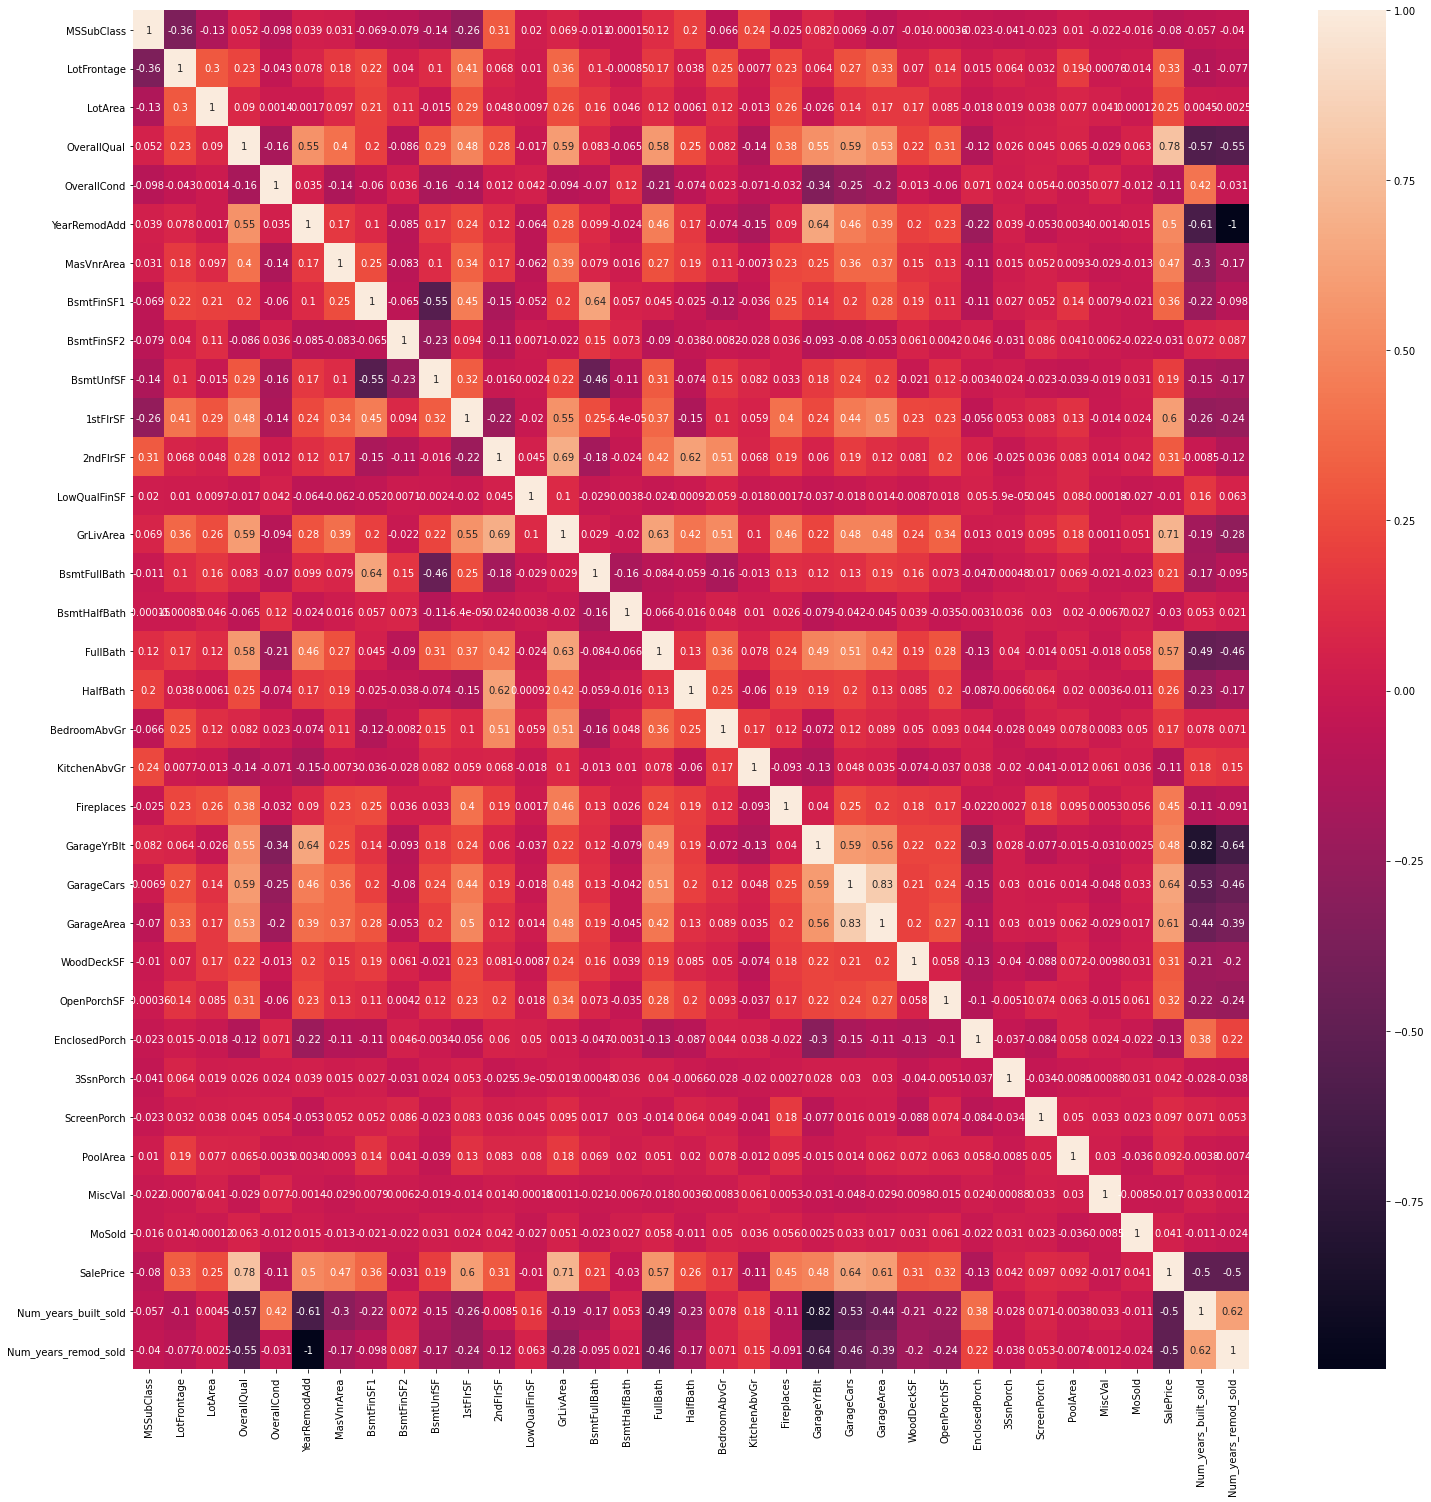

In [32]:
correlation_mat = df_red.corr()

fig, ax = plt.subplots(figsize=(25,25))
sns.heatmap(correlation_mat, annot = True)

##Continuous variable analysis

###KDE Plot

Notice that the data is quite skewed

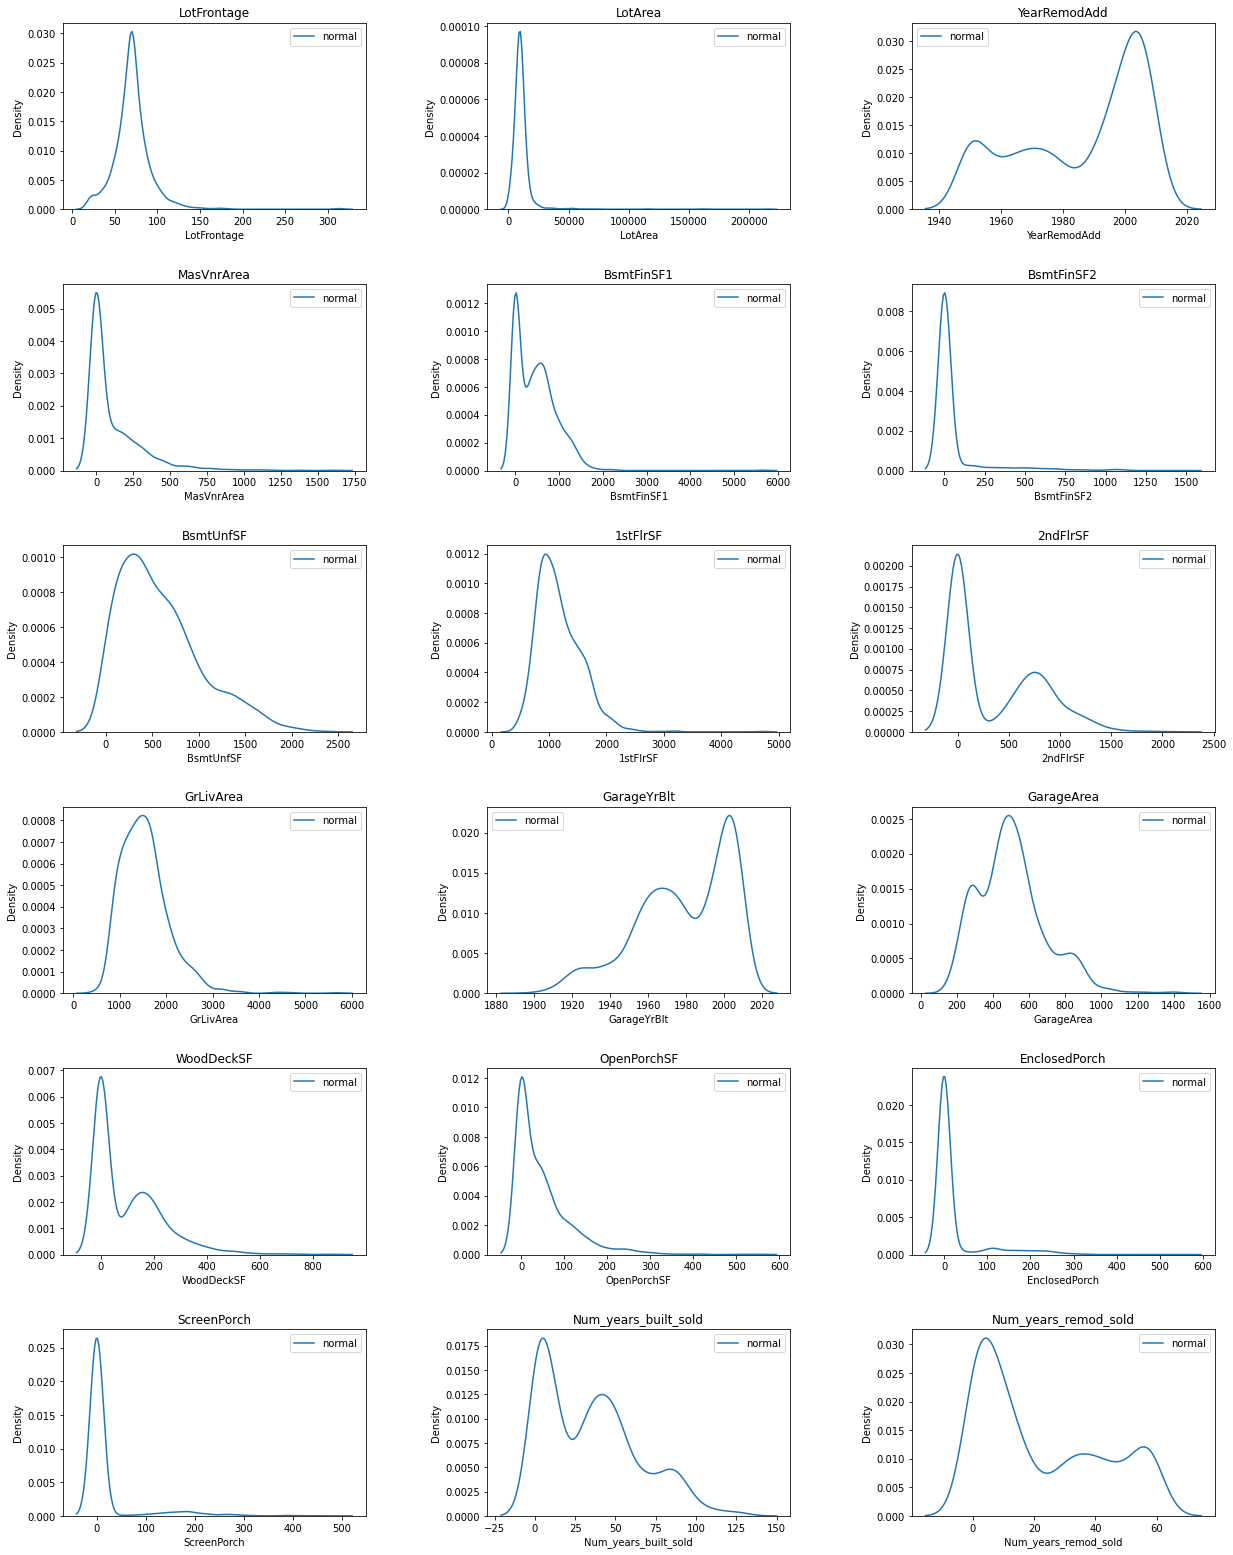

In [33]:
fig = plt.figure(figsize=(20,20))
for x,i in enumerate(features_numeric_cont):
  ax = plt.subplot(8,3,x+1)
  sns.kdeplot(x=df_red[i], label='normal')
  plt.title(f'{i}')
  plt.xlabel(i)
  plt.legend()

  plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.5, 
                    wspace=0.4, 
                    hspace=0.4)

###Scatter-Plots against Sales Price

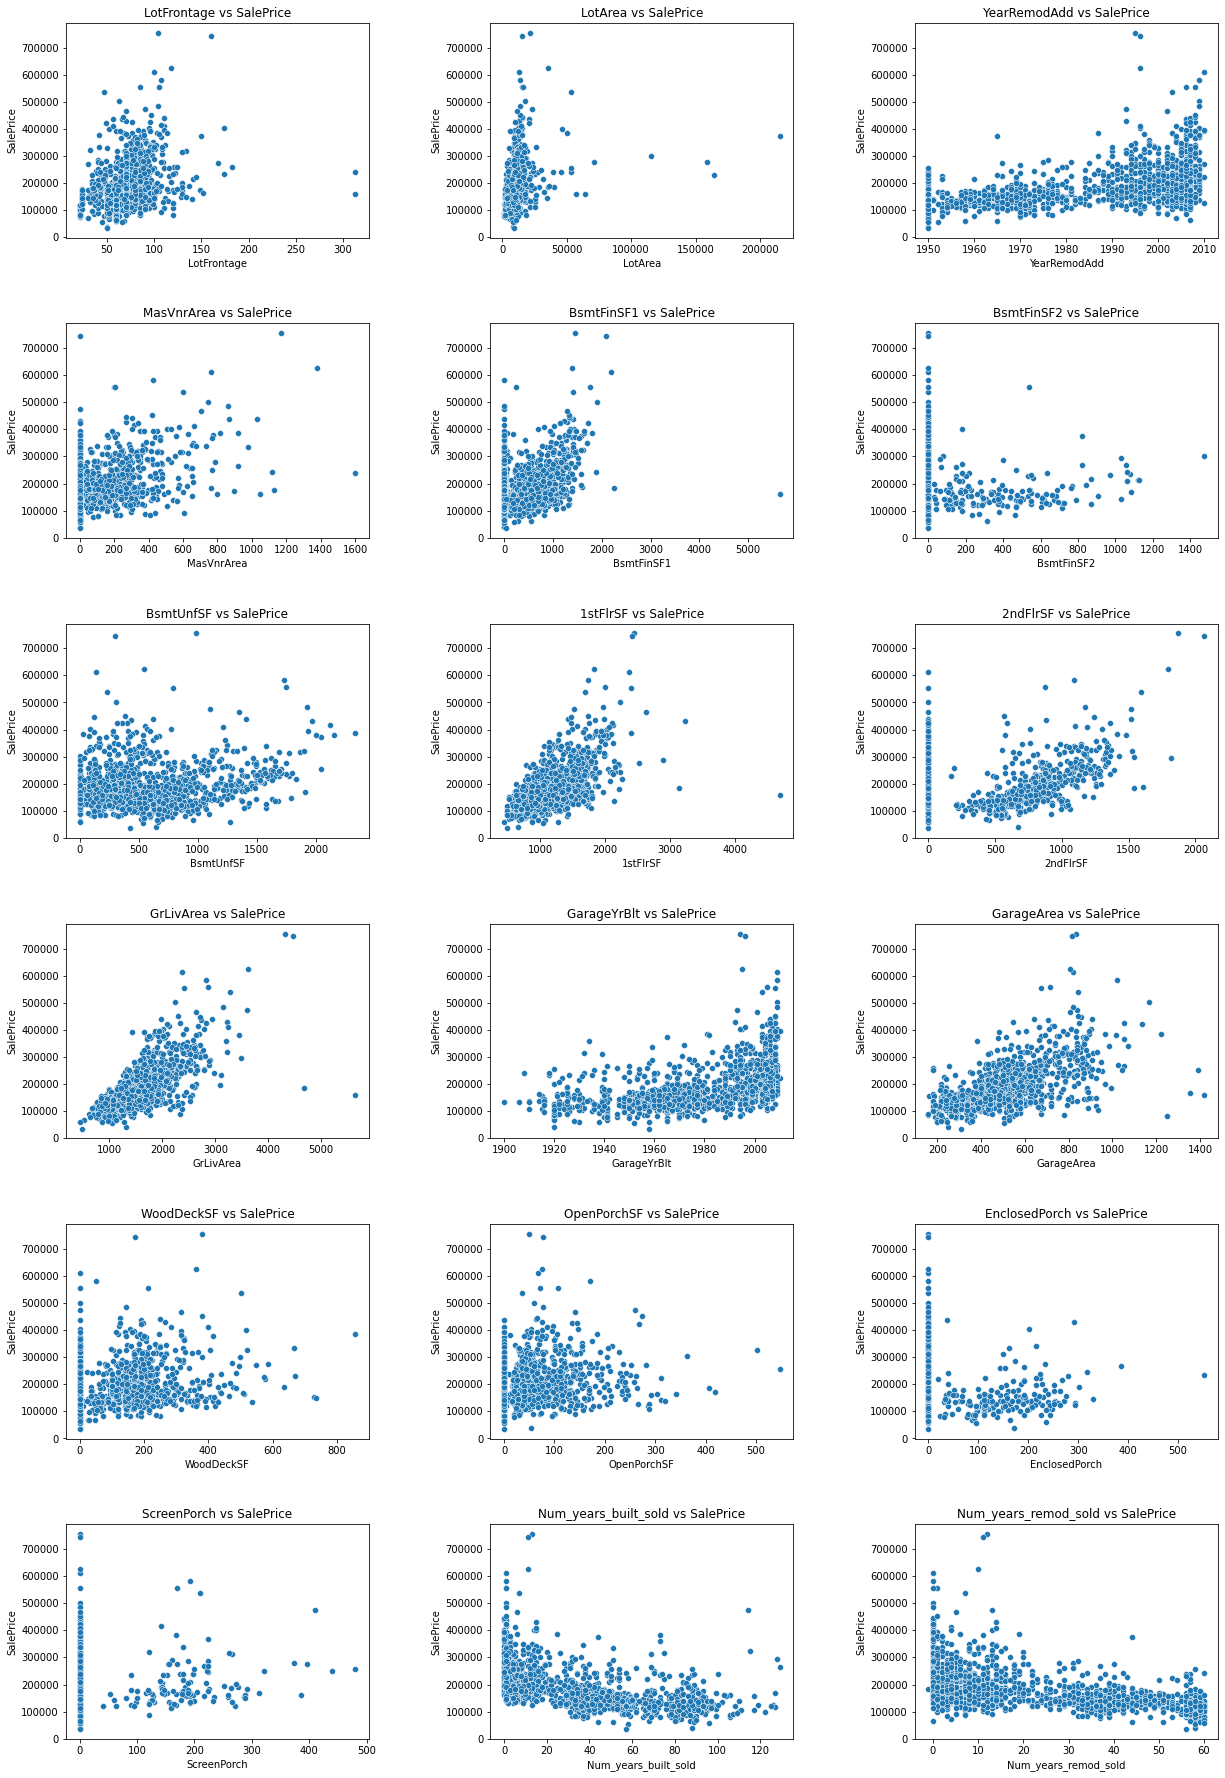

In [34]:
fig = plt.figure(figsize=(20,20))
for x,i in enumerate(features_numeric_cont):
  ax = plt.subplot(7,3,x+1)
  sns.scatterplot(x=df_red[i] ,y=df_red['SalePrice'])
  plt.title(f'{i} vs SalePrice')
  plt.xlabel(i)
  plt.ylabel('SalePrice')

  plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.5, 
                    wspace=0.4, 
                    hspace=0.4)

###Bi-variate Contour Plots againt Sales Price

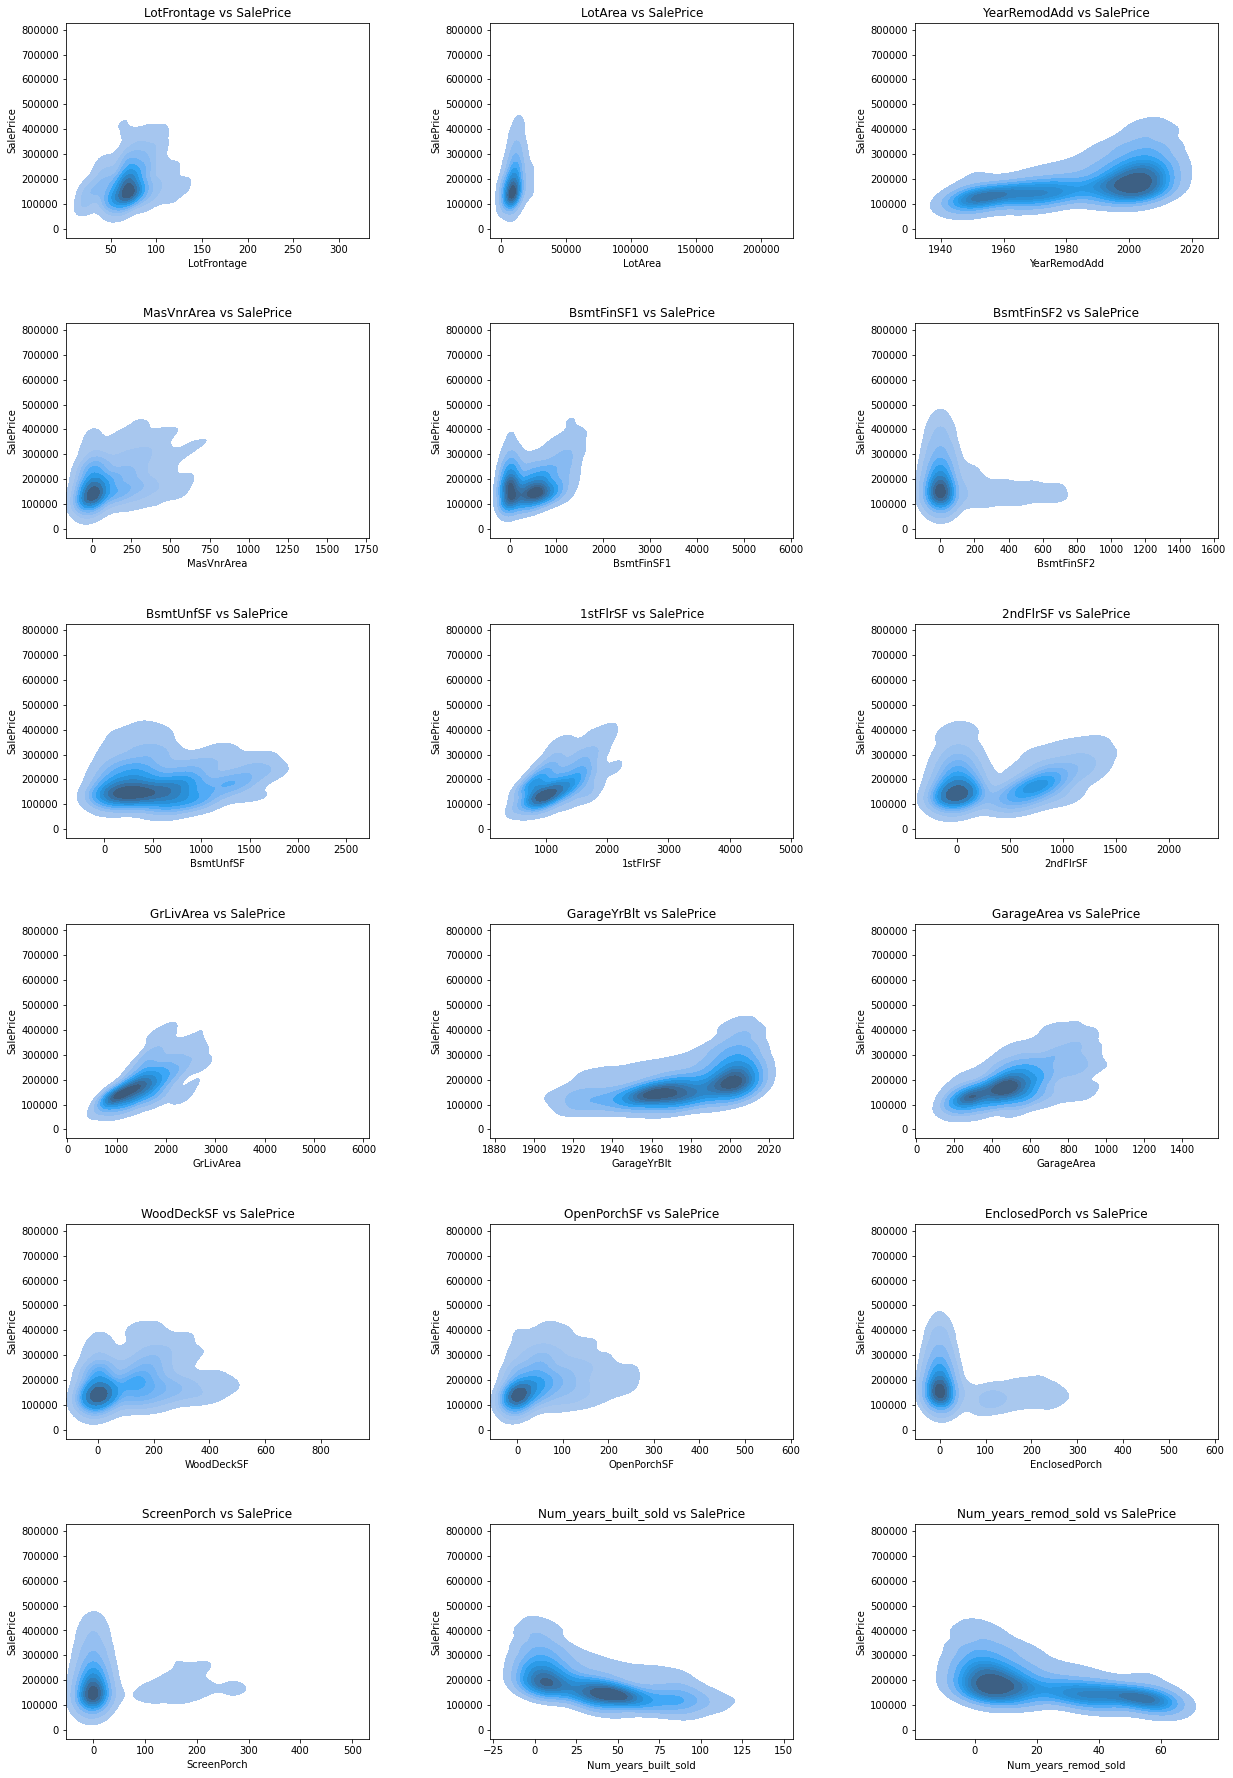

In [35]:
fig = plt.figure(figsize=(20,20))
for x,i in enumerate(features_numeric_cont):
  ax = plt.subplot(7,3,x+1)
  sns.kdeplot(x=df_red[i] ,y=df_red['SalePrice'], fill=True)
  plt.title(f'{i} vs SalePrice')
  plt.xlabel(i)
  plt.ylabel('SalePrice')

  plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.5, 
                    wspace=0.4, 
                    hspace=0.4)

###Observations:

1. As the number of years between Year Built and Year Sold increases the  sale price goes down and most houses have around 10 or 50 years between the two dates.
2. When the houses are remodelled closer to present day the sale price seems to increase, indicating modern houses and designs are preferred. Most houses seem to have been remodelled in the 2000s.
3. Garage Area seems to have a linear correlation with the Sale Price.

 

###Performing log transformation on the skewed data
Since the continous plots have quite a skew to them we will log-transform the data to get a more normal distribution

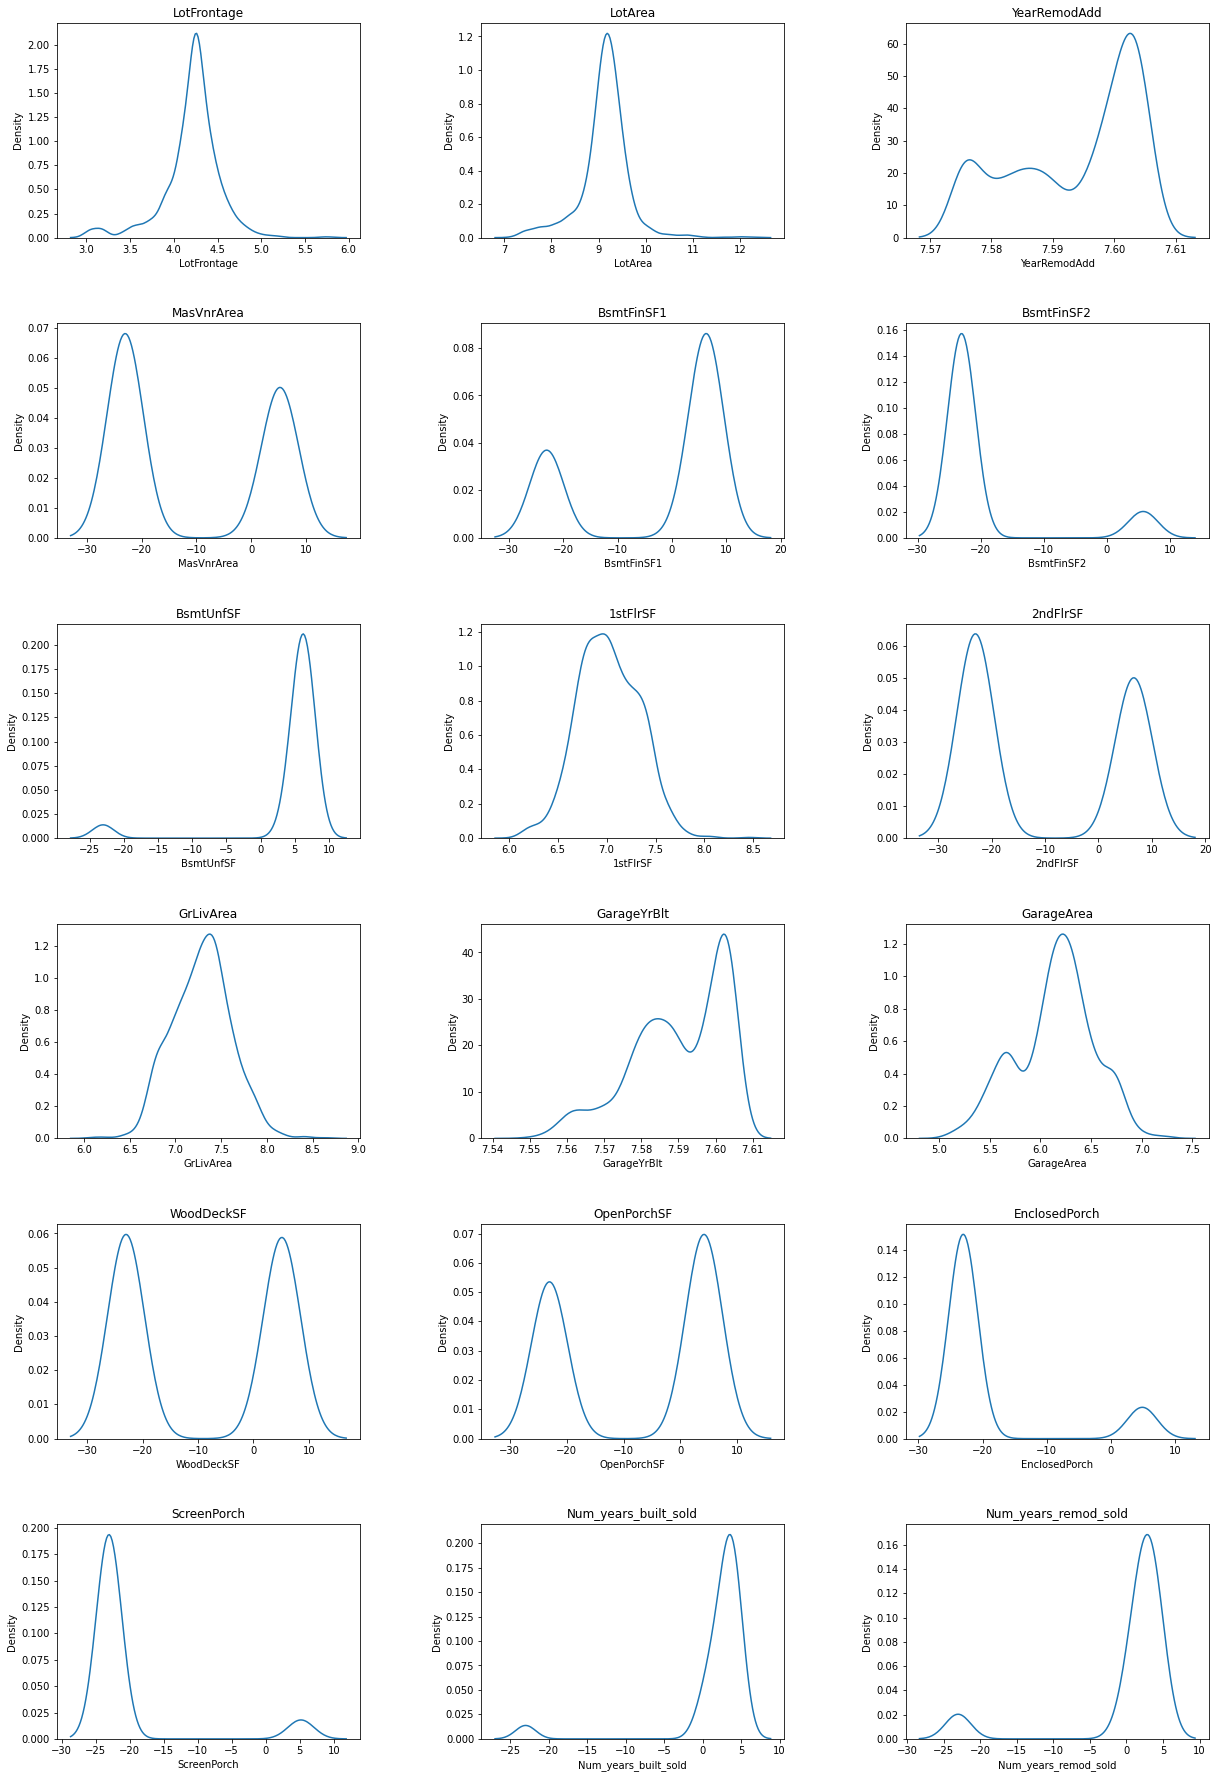

In [36]:
fig = plt.figure(figsize=(20,20))
for x,i in enumerate(features_numeric_cont):
  ax = plt.subplot(7,3,x+1)
  df_red[i] = np.log(np.where(df_red[i] > 1.0e-10 , df_red[i], 1.0e-10))
  sns.kdeplot(x= df_red[i], label='log')
  plt.title(f'{i}')
  plt.xlabel(i)

  plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.5, 
                    wspace=0.4, 
                    hspace=0.4)

##Discrete variable analysis

###Histogram

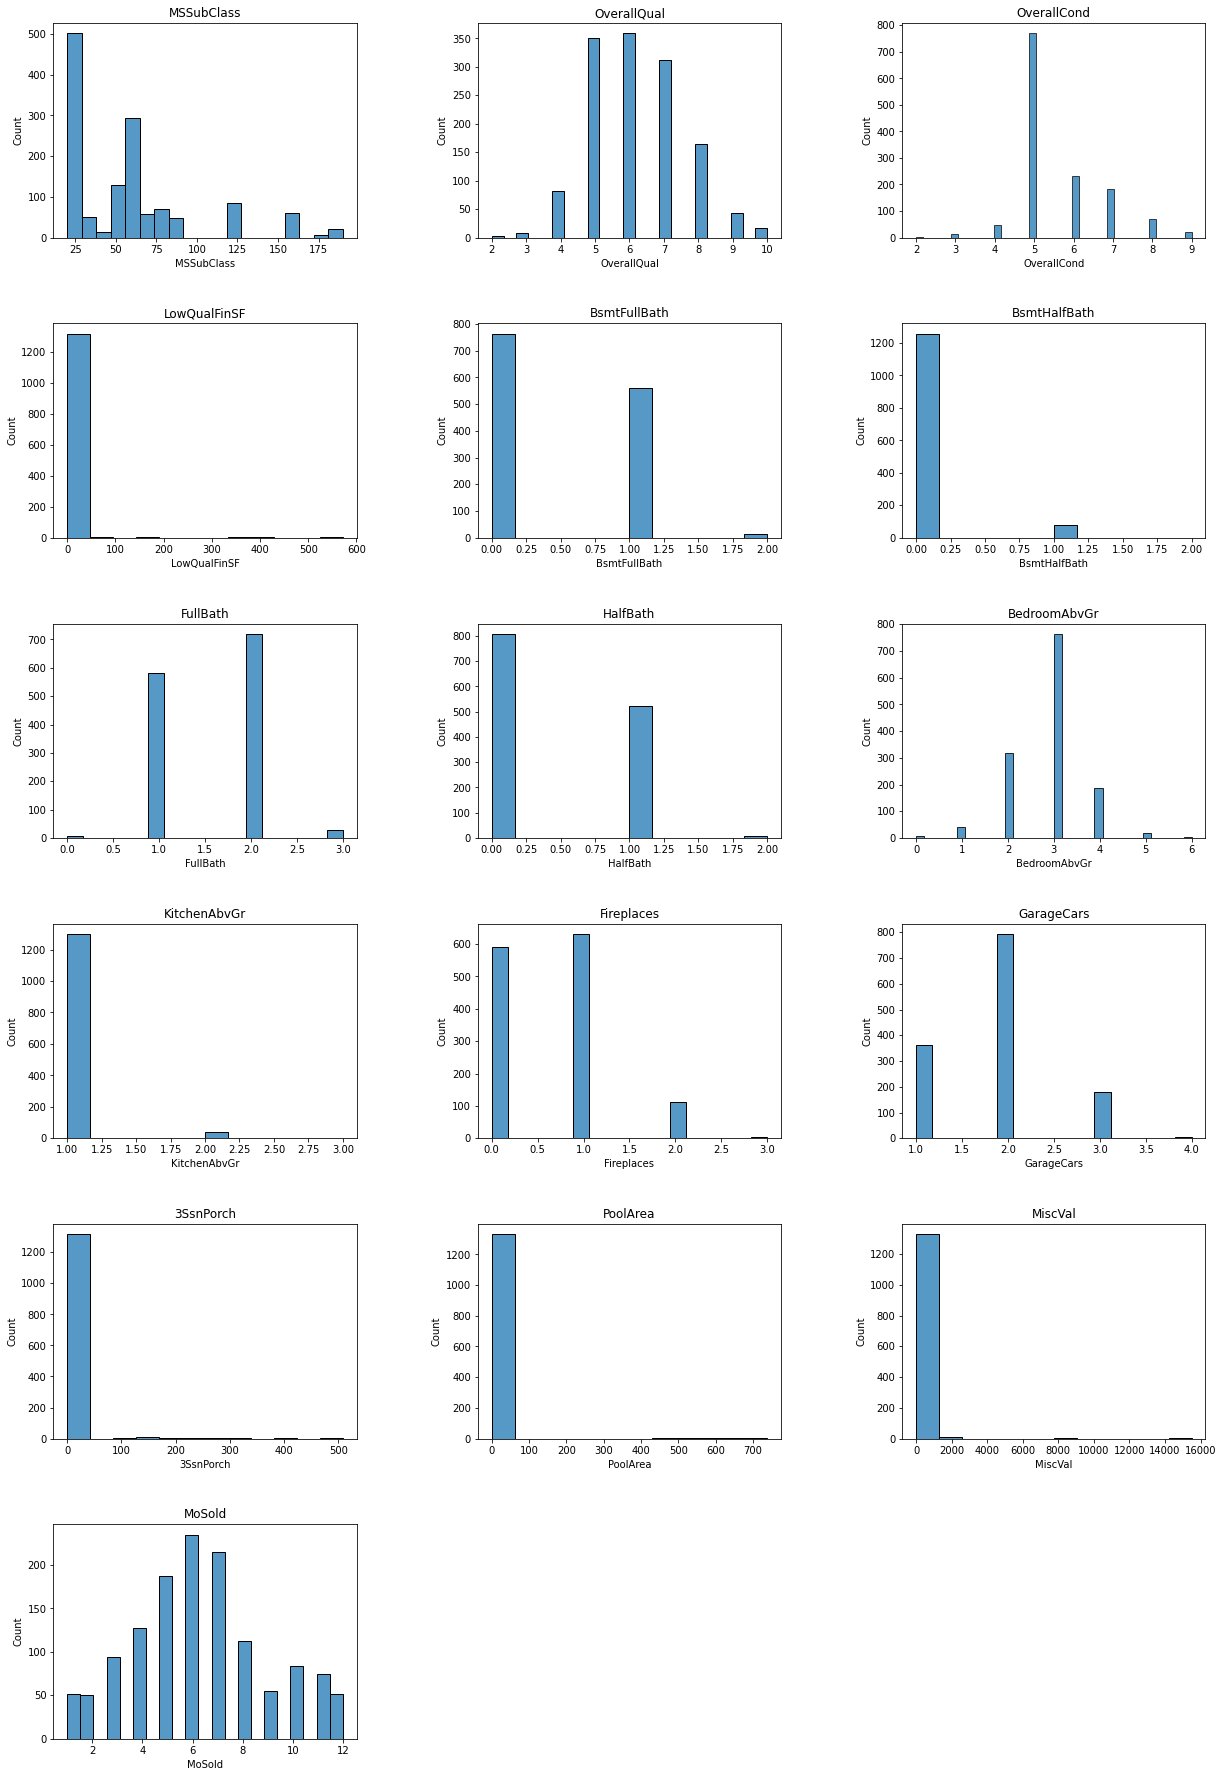

In [37]:
fig = plt.figure(figsize=(20,20))
for x,i in enumerate(features_numeric_dis):
  ax = plt.subplot(7,3,x+1)
  sns.histplot(x=df_red[i])
  plt.title(f'{i}')
  plt.xlabel(i)

  plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.5, 
                    wspace=0.4, 
                    hspace=0.4)

###Box-Plot

The box-plots give us insights into the quartile ranges of the data and also provide information about the outliers.

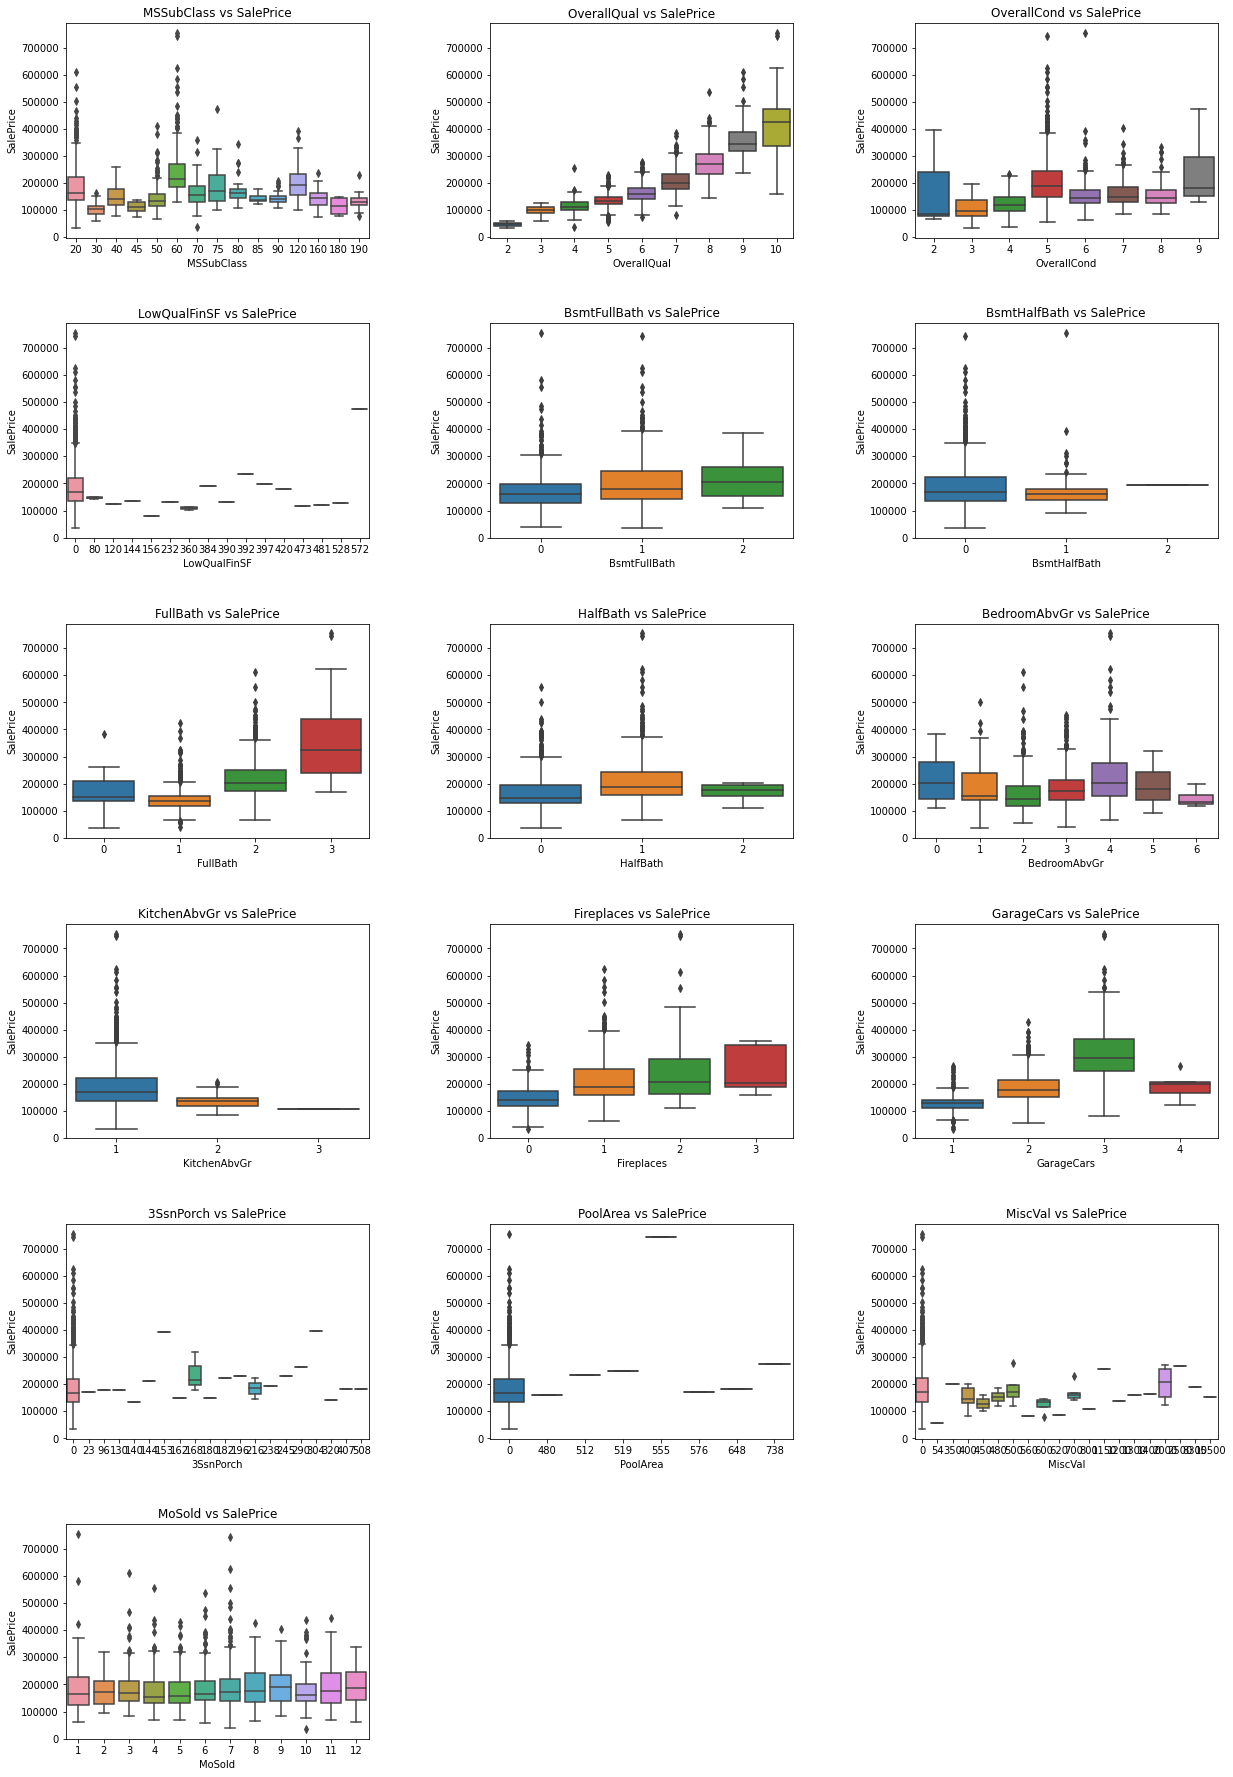

In [38]:
fig = plt.figure(figsize=(20,20))
for x,i in enumerate(features_numeric_dis):
  ax = plt.subplot(7,3,x+1)
  sns.boxplot(x=df_red[i] ,y=df_red['SalePrice'])
  plt.title(f'{i} vs SalePrice')
  plt.xlabel(i)
  plt.ylabel('SalePrice')

  plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.5, 
                    wspace=0.4, 
                    hspace=0.4)

###Bar charts

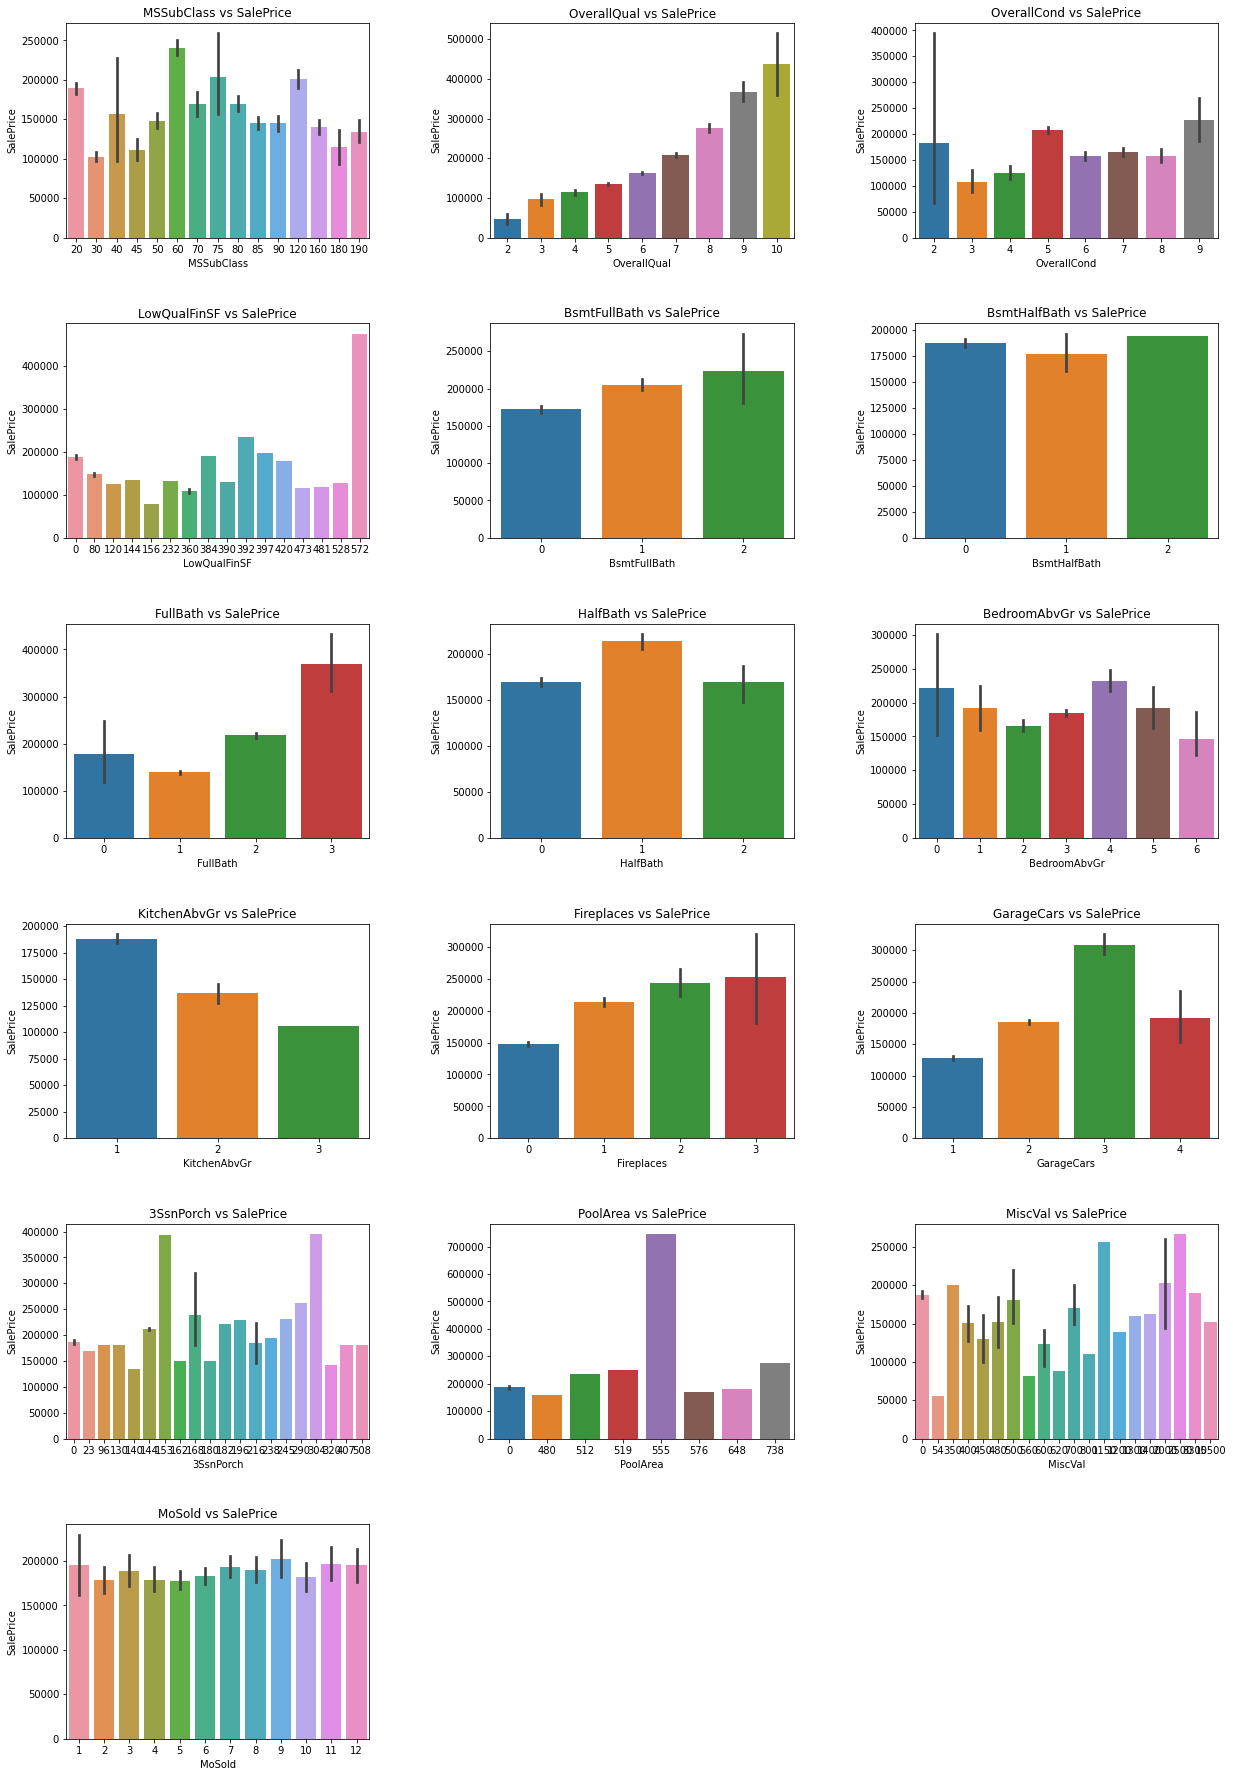

In [39]:
fig = plt.figure(figsize=(20,20))
for x,i in enumerate(features_numeric_dis):
  ax = plt.subplot(7,3,x+1)
  sns.barplot(x=df_red[i] ,y=df_red['SalePrice'])
  plt.title(f'{i} vs SalePrice')
  plt.xlabel(i)
  plt.ylabel('SalePrice')

  plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.5, 
                    wspace=0.4, 
                    hspace=0.4)

###Observations:
1. A linear positive correlation between over all quality and sales price and *is a key indicator*.
2. There are outlier conditions where houses with poor condition(2) have been sold for extremely high values
3. Garages for 3 cars seem to be the most expensive.

##Categorical variable analysis

###Box-plots against sales price

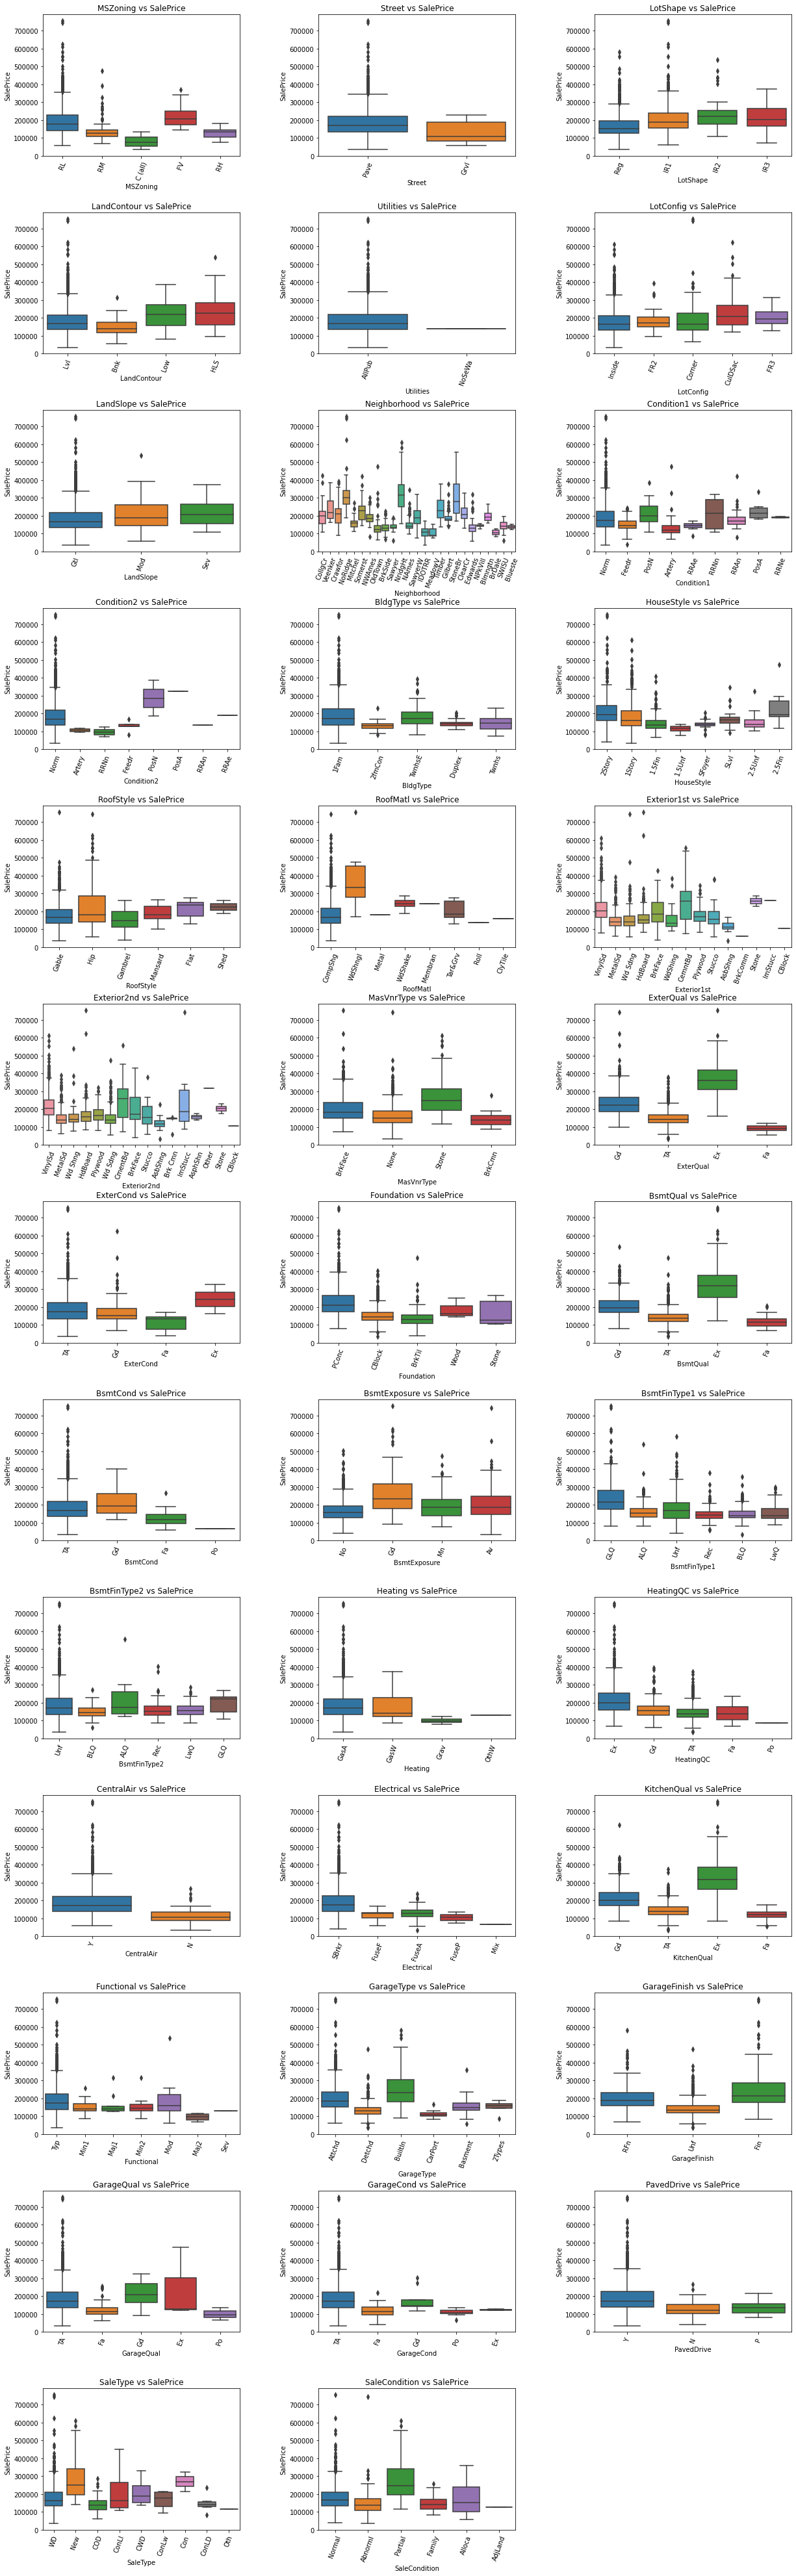

In [40]:
fig = plt.figure(figsize=(20,20))
for x,i in enumerate(features_cat):
  ax = plt.subplot(np.round(len(features_cat)/3)+1,3,x+1)
  #print(i,':',pd.unique(df_red[i]))
  sns.boxplot(x=i, y='SalePrice', data=df_red)
  plt.title(f'{i} vs SalePrice')
  plt.xlabel(i)
  plt.xticks(rotation=70)
  plt.ylabel('SalePrice')

  plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=3, 
                    wspace=0.4, 
                    hspace=0.4)

###Histogram

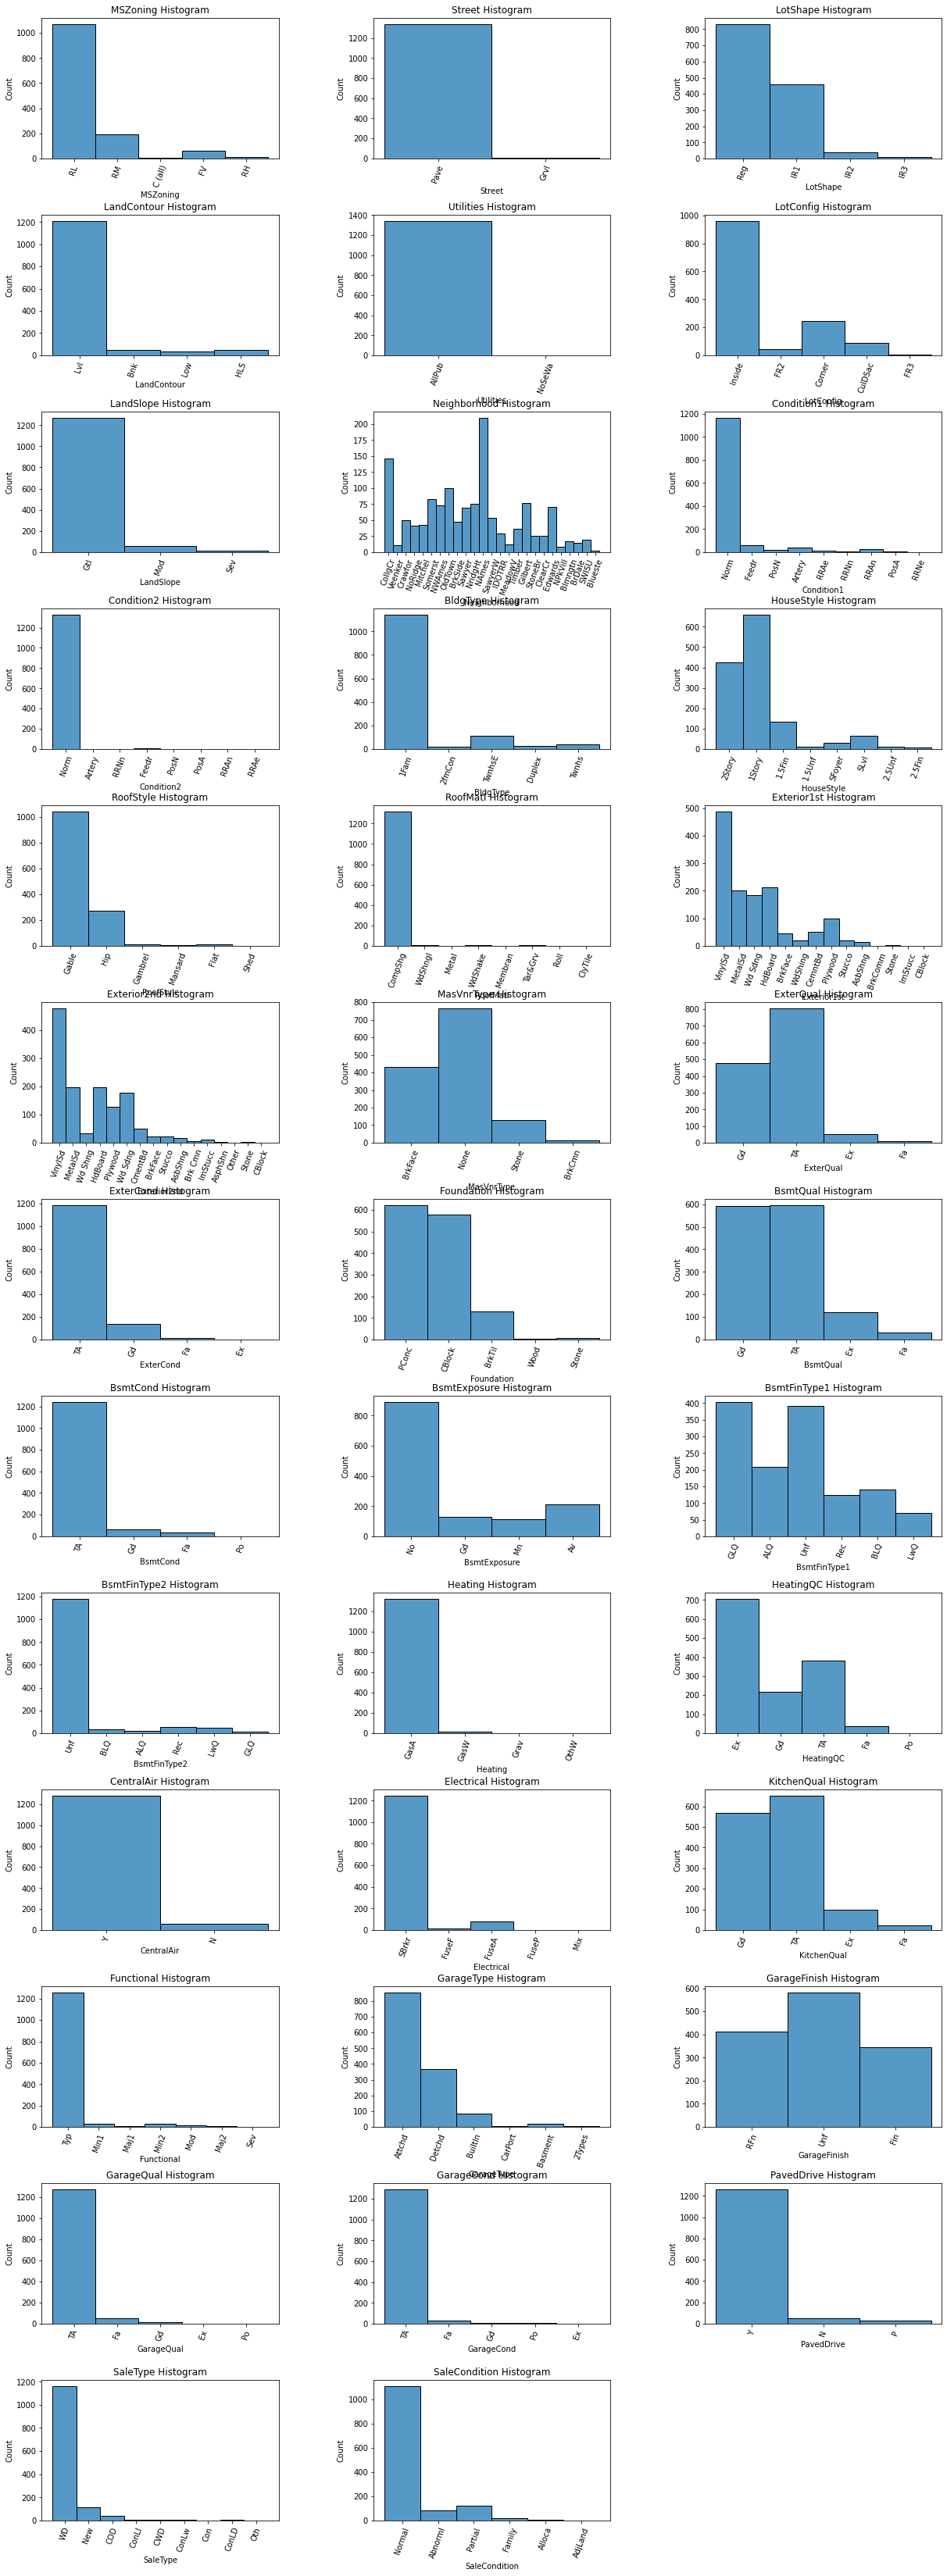

In [41]:
fig = plt.figure(figsize=(20,20))
for x,i in enumerate(features_cat):
  ax = plt.subplot(np.round(len(features_cat)/3)+1,3,x+1)
  sns.histplot(x=i, data=df_red)
  plt.title(f'{i} Histogram')
  plt.xlabel(i)
  plt.xticks(rotation=70)

  plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=2.5, 
                    wspace=0.4, 
                    hspace=0.4)

###Observations:
- Neigbourhood seems to affect Sales Price drastically.
- Materials used for roofing, exteriors have an impact on price.
- Basement conditions such as quality, exposure seem to be of noticable importance. 

#Preparing data for ML algorithms

##One Hot Encoding Categorical Variables

In [42]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_cat)
X_cat_enc = enc.transform(X_cat)
OneHotEncoder(handle_unknown='ignore')

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='ignore', sparse=True)

In [43]:
cat_df = pd.DataFrame(X_cat_enc.todense())

In [44]:
# X_fin = pd.concat([num_df, cat_df],1)

In [45]:
print(X_numeric.shape)
print(cat_df.shape)
X_numeric.reset_index(drop=True, inplace=True) 
cat_df.reset_index(drop=True, inplace=True) 

(1338, 34)
(1338, 229)


In [46]:
from sklearn.preprocessing import StandardScaler
X_scal = StandardScaler().fit_transform(X_numeric)
#X_scal = pd.DataFrame(X_scal)

In [47]:
X_scal = pd.DataFrame(X_scal, columns = X_numeric.columns)

In [48]:
X_fin = pd.concat([X_scal, cat_df],1)

In [49]:
print(X_fin.shape)
X_fin

(1338, 263)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,Num_years_built_sold,Num_years_remod_sold,0,1,2,3,4,5,...,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228
0,0.093701,-0.254147,-0.218363,0.589337,-0.553402,0.854216,0.461582,0.527157,-0.296255,-0.983421,-0.828516,1.128813,-0.10374,0.331321,1.088949,-0.250577,0.775560,1.184848,0.174239,-0.17119,-1.005546,0.985427,0.202747,0.249341,-0.779554,0.202294,-0.349612,-0.118688,-0.283203,-0.071771,-0.084535,-1.605319,-1.006205,-0.844734,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.876298,0.422953,-0.107067,-0.165963,2.230251,-0.476562,-0.594820,1.120240,-0.296255,-0.678727,0.221935,-0.811389,-0.10374,-0.529579,-0.851149,3.888586,0.775560,-0.799291,0.174239,-0.17119,0.544478,-0.104844,0.202747,-0.222023,1.557895,-0.731311,-0.349612,-0.118688,-0.283203,-0.071771,-0.084535,-0.493561,-0.127616,0.436901,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.093701,-0.118727,0.052620,0.589337,-0.553402,0.804928,0.278328,0.047458,-0.296255,-0.337652,-0.662928,1.156076,-0.10374,0.477367,1.088949,-0.250577,0.775560,1.184848,0.174239,-0.17119,0.544478,0.904666,0.202747,0.570726,-0.779554,-0.088501,-0.349612,-0.118688,-0.283203,-0.071771,-0.084535,0.988784,-0.938621,-0.795440,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.336201,-0.479847,-0.111906,0.589337,-0.553402,-0.772291,-0.594820,-0.541263,-0.296255,-0.096626,-0.556848,0.906167,-0.10374,0.344773,1.088949,-0.250577,-1.051375,-0.799291,0.174239,-0.17119,0.544478,0.783525,1.779928,0.752844,-0.779554,-0.195636,4.122511,-0.118688,-0.283203,-0.071771,-0.084535,-1.605319,1.899897,0.683369,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.093701,0.603514,0.343926,1.344638,-0.553402,0.706352,1.291612,0.415954,-0.296255,-0.210318,-0.080781,1.580921,-0.10374,1.269088,1.088949,-0.250577,0.775560,1.184848,1.462256,-0.17119,0.544478,0.864286,1.779928,1.791989,0.726453,0.554309,-0.349612,-0.118688,-0.283203,-0.071771,-0.084535,2.100542,-0.904829,-0.696853,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,0.093701,-0.389567,-0.269947,-0.165963,-0.553402,0.706352,-0.594820,-1.012240,-0.296255,0.842467,-0.577546,0.765309,-0.10374,0.210257,-0.851149,-0.250577,0.775560,1.184848,0.174239,-0.17119,0.544478,0.823905,0.202747,-0.222023,-0.779554,-0.119111,-0.349612,-0.118688,-0.283203,-0.071771,-0.084535,0.618198,-0.904829,-0.746147,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1334,-0.876298,0.648

##Train-test split

In [50]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_fin,y,test_size = 0.2,random_state = 1)

In [51]:
pd.set_option('display.max_columns', None)
X_fin

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,Num_years_built_sold,Num_years_remod_sold,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228
0,0.093701,-0.254147,-0.218363,0.589337,-0.553402,0.854216,0.461582,0.527157,-0.296255,-0.983421,-0.828516,1.128813,-0.10374,0.331321,1.088949,-0.250577,0.775560,1.184848,0.174239,-0.17119,-1.005546,0.985427,0.202747,0.249341,-0.779554,0.202294,-0.349612,-0.118688,-0.283203,-0.071771,-0.084535,-1.605319,-1.006205,-0.844734,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.876298,0.422953,-0.107067,-0.165963,2.230251,-0.476562,-0.594820,1.120240,-0.296255,-0.678727,0.221935,-0.811389,-0.10374,-0.529579,-0.851149,3.888586,0.775560,-0.799291,0.174239,-0.17119,0.544478,-0.104844,0.202747,-0.222023,1.557895,-0.731311,-0.349612,-0.118688,-0.283203,-0.071771,-0.084535,-0.493561,-0.127616,0.436901,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.093701,-0.118727,0.052620,0.589337,-0.553402,0.804928,0.278328,0.047458,-0.296255,-0.337652,-0.662928,1.156076,-0.10374,0.477367,1.088949,-0.250577,0.775560,1.184848,0.174239,-0.17119,0.544478,0.904666,0.202747,0.570726,-0.779554,-0.088501,-0.349612,-0.118688,-0.283203,-0.071771,-0.084535,0.988784,-0.938621,-0

#Model Implementation

In [52]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [53]:
y_test_arr = y_test.to_numpy()

In [54]:
y_test_arr = y_test_arr.reshape(len(y_test_arr),1)

## Random Forest Regression

In [55]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [56]:
y_pred = regressor.predict(X_test)
np.set_printoptions(precision=2)
len(y_pred)
# y_pred.reshape(1,)
# print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

268

In [57]:
y_pred_arr= y_pred.reshape(len(y_pred),1)

In [58]:
from sklearn.metrics import r2_score
r2_score(y_test_arr, y_pred_arr)

0.7849490940536861

##XGBRegressor

In [59]:
import xgboost
xg_regressor = xgboost.XGBRegressor()
xg_regressor.fit(X_train, y_train)

[08:09:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [60]:
y_pred_xg = xg_regressor.predict(X_test)
np.set_printoptions(precision=2)

In [61]:
y_pred_arr_xg= y_pred_xg.reshape(len(y_pred),1)

In [62]:
from sklearn.metrics import r2_score
r2_score(y_test_arr, y_pred_arr_xg)

0.8050730893475222

##LightGBM

In [63]:
import lightgbm as lgb
lgb_regressor = lgb.LGBMRegressor()
lgb_regressor.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [64]:
y_pred_lgb = lgb_regressor.predict(X_test)
np.set_printoptions(precision=2)

In [65]:
y_pred_arr_lgb= y_pred_lgb.reshape(len(y_pred),1)

In [66]:
from sklearn.metrics import r2_score
r2_score(y_test_arr, y_pred_arr_lgb)

0.7938183741150169

## Training results (R2 scores):
- XGBRegressor --> 80%
- LightGBM --> 79%
- RandomForestRegression --> 78%